<a href="https://colab.research.google.com/github/jashvidesai/ORF-Thesis/blob/main/SplitDelivery_Heterogenous_VRPTW.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install gurobipy

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.4/14.4 MB 42.4 MB/s eta 0:00:00


In [11]:
import gurobipy as gp
from gurobipy import GRB
import numpy as np

# Example parameters
V = range(6)  # nodes including depot, 0 is depot
V_star = range(1, 6)  # nodes excluding depot
K = range(3)  # three vehicles with heterogeneous capacities
Q = [45, 40, 55]  # capacity of each vehicle
vehicle_speed = 60  # vehicle speed in km/h
fixed_costs = [110, 100, 105]  # fixed costs for each vehicle

# DISTANCES!
np.random.seed(42)
distances = np.random.randint(10, 51, size=(len(V), len(V)))
for i in V:
    distances[i, i] = 0
    for j in range(i + 1, len(V)):
        distances[j, i] = distances[i, j]
for i in V:
    for j in V:
        for k in V:
            if distances[i, j] > distances[i, k] + distances[k, j]:
                distances[i, j] = distances[i, k] + distances[k, j]

t = distances / vehicle_speed  # travel times
c = distances * 0.093  # travel costs (arbitrary scaling for fuel)

# Sample demands (including depot which has 0 demand)
d = [0, 30, 35, 20, 25, 30]  # Adjusted demands

# Time window parameters
a = [0, 5, 10, 20, 20, 5]  # Earliest arrival times
b = [30, 25, 35, 30, 30, 15]  # Latest departure times
s = [0, 10, 10, 7, 5, 5]  # Service times

# Model setup
model = gp.Model("Heterogeneous_Split_Delivery_VRPTW")

# Decision variables
x = model.addVars(V, V, K, vtype=GRB.BINARY, name="x")  # binary: whether vehicle k travels from i to j
q = model.addVars(V, K, vtype=GRB.CONTINUOUS, name="q")  # continuous: cumulative demand on vehicle k at node i
tau = model.addVars(V, K, vtype=GRB.CONTINUOUS, name="tau")  # continuous: arrival time of vehicle k at node i

# Add new continuous variables for load delivered to each node
y = model.addVars(V_star, K, vtype=GRB.CONTINUOUS, name="y")

# Objective: Minimize total travel cost
model.setObjective(
    gp.quicksum(c[i, j] * x[i, j, k] for i in V for j in V for k in K if i != j) +
    gp.quicksum(fixed_costs[k] * gp.quicksum(x[0, j, k] for j in V_star) for k in K),
    GRB.MINIMIZE
)

# Constraints

# Constraint 1: each vehicle visited by at least one customer
model.addConstrs(
    (gp.quicksum(x[i, j, k] for i in V for k in K) >= 1 for j in V_star),
    name="visit_customer_once"
)

# Constraint 2: each vehicle departed from by at least one customer
model.addConstrs(
    (gp.quicksum(x[i, j, k] for j in V for k in K) >= 1 for i in V_star),
    name="departure_from_node_once"
)

# Constraint 3: Ensure each vehicle departs the depot at most once
model.addConstrs(
    (gp.quicksum(x[0, j, k] for j in V_star) == 1 for k in K),
    name="vehicle_depart_depot_once"
)

# Constraint 4: Ensure each vehicle returns to the depot at most once
model.addConstrs(
    (gp.quicksum(x[i, 0, k] for i in V_star) == 1 for k in K),
    name="vehicle_return_depot_once"
)

# Constraint 5 (unchanged): Flow Conservation
model.addConstrs(
    (gp.quicksum(x[i, j, k] for i in V if j != i) == gp.quicksum(x[j, i, k] for i in V if j != i)
    for j in V_star for k in K),
    name="flow_conservation"
)

# Constraint 6 (unchanged): No self-loops
#model.addConstr(
    #((gp.quicksum((x[i, j, k] for i in V_star if i != j)) - (gp.quicksum(x[j, l, k] for l in V_star if l != j)) = 0) for j in V_star for k in K)
#)
model.addConstrs(
    (x[i, i, k] == 0 for i in V for k in K),
    name="no_self_loops"
)

# Constraint 7: Depot load initialization
model.addConstrs(
    (q[0, k] == 0 for k in K),
    name="depot_load"
)

# Constraint 8: Capacity bound
model.addConstrs(
    (q[i, k] >= d[i] for i in V_star for k in K),
    name="load_lower_bound"
)
model.addConstrs(
    (q[i, k] <= Q[k] for i in V_star for k in K),
    name="load_upper_bound"
)

# Constraint 9: Demand Fulfillment
model.addConstrs(
    (gp.quicksum(y[i, k] for k in K) == d[i] for i in V_star),
    name="demand_fulfillment"
)

# Constraint 10: Vehicle capacity with delivered loads
model.addConstrs(
    (gp.quicksum(y[i, k] for i in V_star) <= Q[k] for k in K),
    name="vehicle_capacity"
)

# Constraint 11: Load delivery bounds
model.addConstrs(
    (y[i, k] >= 0 for i in V_star for k in K),
    name="non_negative_load"
)
model.addConstrs(
    (y[i, k] <= d[i] for i in V_star for k in K),
    name="max_load_per_node"
)

# Constraint 12: Bound 1
model.addConstrs(
    (q[i, k] + y[j, k] <= q[j, k] + Q[k] * (1 - x[i, j, k])
     for i in V_star for j in V_star for k in K if i != j),
    name="load_progression_upper"
)

# Constraint 13: Bound 2
M = {(i, k): Q[k] - d[i] for i in V_star for k in K}

model.addConstrs(
    (q[i, k] + y[j, k] >= q[j, k] - M[i, k] * (1 - x[i, j, k])
     for i in V_star for j in V_star for k in K if i != j),
    name="load_progression_lower"
)

# Constraint 14: Consistency between x and y: Delivery can only happen if the node is visited
model.addConstrs(
    (y[i, k] <= d[i] * gp.quicksum(x[j, i, k] for j in V) for i in V_star for k in K),
    name="load_delivery_consistency"
)

# Constraint 14 (unchanged): Time Window #1
model.addConstrs(
    (tau[0, k] == 0 for k in K),
    name="depot_time"
)

# Constraint 15 (unchanged): Time Window #2
model.addConstrs(
    (a[i] <= tau[i, k] for i in V_star for k in K),
    name="time_window_start"
)
model.addConstrs(
    (tau[i, k] <= b[i] for i in V_star for k in K),
    name="time_window_end"
)

# Constraint 16 (unchanged): Time Window #3
M_2 = {(i, j, k): b[i] - a[j] + s[i] + t[i, j] for i in V_star for j in V_star for k in K if i != j}
model.addConstrs(
    (tau[i, k] + s[i] + t[i, j] <= tau[j, k] + M_2[i, j, k] * (1 - x[i, j, k])
     for i in V_star for j in V_star for k in K if i != j),
    name="service_time"
)

# Solve the model
model.optimize()

# Output results
if model.status == GRB.OPTIMAL:
    print("\n--- Debug: Decision Variable Values ---")
    print("Travel Decisions (x[i, j, k]):")
    for k in K:
        for i in V:
            for j in V:
                if x[i, j, k].x > 0.5:  # Print only active decisions
                    print(f"x[{i}, {j}, {k}] = {x[i, j, k].x:.2f}")

    print("\nLoad Deliveries (y[i, k]):")
    for k in K:
        for i in V_star:
            if y[i, k].x > 0:  # Print only non-zero deliveries
                print(f"y[{i}, {k}] = {y[i, k].x:.2f}")

    print("\n--- Vehicle Routes and Load Deliveries ---")
    for k in K:
        # Route construction based on x[i, j, k] and y[i, k]
        route = [0]  # Start at the depot
        visited_nodes = set(route)  # Track visited nodes

        # Build the route based on x[i, j, k]
        current_node = 0
        while True:
            found_next = False
            for j in V:
                if x[current_node, j, k].x > 0.5 and current_node != j and j not in visited_nodes:
                    route.append(j)
                    visited_nodes.add(j)
                    current_node = j
                    found_next = True
                    break
            if not found_next or current_node == 0:
                break

        # Include nodes with deliveries (y[i, k] > 0) if they are not already in the route
        for i in V_star:
            if y[i, k].x > 0 and i not in visited_nodes:
                # Insert at the appropriate position (before returning to the depot)
                route.insert(-1, i)
                visited_nodes.add(i)

        # Ensure the route ends at the depot
        if route[-1] != 0:
            route.append(0)

        # Print the route
        print(f"Vehicle {k} route: {' -> '.join(map(str, route))}")
        total_cost = sum(c[route[i], route[i+1]] for i in range(len(route) - 1))
        print(f"Total cost for Vehicle {k}: {total_cost:.2f}")

        # Print loads delivered by the vehicle
        print(f"Loads delivered by Vehicle {k}:")
        for i in V_star:
            if y[i, k].x > 0:  # Check if the vehicle delivered to this node
                print(f"  Node {i}: {y[i, k].x:.2f} units")


Gurobi Optimizer version 12.0.0 build v12.0.0rc1 (linux64 - "Ubuntu 22.04.3 LTS")

CPU model: Intel(R) Xeon(R) CPU @ 2.20GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 1 physical cores, 2 logical processors, using up to 2 threads

Optimize a model with 348 rows, 159 columns and 1269 nonzeros
Model fingerprint: 0xf9b824b3
Variable types: 51 continuous, 108 integer (108 binary)
Coefficient statistics:
  Matrix range     [3e-01, 6e+01]
  Objective range  [1e+00, 1e+02]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 6e+01]
Presolve removed 174 rows and 45 columns
Presolve time: 0.01s
Presolved: 174 rows, 114 columns, 876 nonzeros
Variable types: 42 continuous, 72 integer (72 binary)
Found heuristic solution: objective 339.6450000

Root relaxation: objective 3.346822e+02, 113 iterations, 0.00 seconds (0.00 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     

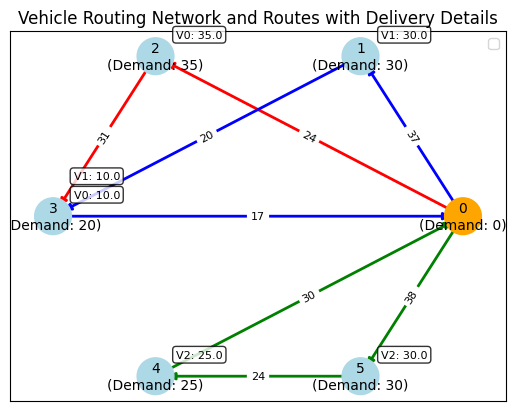


Additional Information:
Vehicle 0: Fixed Cost = 110
  Total Demand Fulfilled by Vehicle 0: 55
  Total Capacity: 45

Vehicle 1: Fixed Cost = 100
  Total Demand Fulfilled by Vehicle 1: 50
  Total Capacity: 40

Vehicle 2: Fixed Cost = 105
  Total Demand Fulfilled by Vehicle 2: 55
  Total Capacity: 55



In [12]:
import matplotlib.pyplot as plt
import networkx as nx

def visualize_routes_with_spacing(V, V_star, K, distances, x, y, q, fixed_costs, d):
    # Create the graph
    G = nx.DiGraph()

    # Add nodes
    for i in V:
        G.add_node(i, demand=d[i])

    # Add edges for all vehicles
    edge_colors = ['red', 'blue', 'green']
    for k in K:
        for i in V:
            for j in V:
                if i != j and x[i, j, k].x > 0.5:
                    G.add_edge(i, j, vehicle=k, weight=distances[i][j])

    # Node positions (circle layout)
    pos = nx.circular_layout(G)

    # Draw nodes
    node_colors = ['orange' if i == 0 else 'lightblue' for i in V]
    node_labels = {i: f"{i}\n(Demand: {d[i]})" for i in V}
    nx.draw_networkx_nodes(G, pos, node_color=node_colors, node_size=700)
    nx.draw_networkx_labels(G, pos, labels=node_labels, font_size=10)

    # Draw edges
    for k in K:
        edges_k = [(i, j) for i, j in G.edges if G[i][j]['vehicle'] == k]
        nx.draw_networkx_edges(G, pos, edgelist=edges_k, edge_color=edge_colors[k], width=2, label=f"Vehicle {k}")

    # Draw edge labels (travel costs)
    edge_labels = {(i, j): f"{distances[i][j]}" for i, j in G.edges}
    nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_size=8)

    # Add delivery amounts next to nodes with spacing
    for i in V_star:
        deliveries = []
        for k in K:
            if y[i, k].x > 0:  # Check if there's delivery to the node
                deliveries.append(f"V{k}: {y[i, k].x:.1f}")

        # Add spaced text near the node
        for idx, delivery in enumerate(deliveries):
            x_offset, y_offset = 0.1, 0.1 + idx * 0.1  # Adjust vertical spacing for multiple entries
            plt.text(
                pos[i][0] + x_offset,
                pos[i][1] + y_offset,
                delivery,
                fontsize=8,
                bbox=dict(facecolor='white', alpha=0.8, boxstyle='round,pad=0.3')
            )

    # Add legend and title
    plt.legend(loc='upper right', fontsize=10)
    plt.title("Vehicle Routing Network and Routes with Delivery Details")
    plt.show()

    # Print additional information
    print("\nAdditional Information:")
    for k in K:
        print(f"Vehicle {k}: Fixed Cost = {fixed_costs[k]}")
        route_demand = sum(d[i] for i in V_star if sum(x[i, j, k].x for j in V) > 0)
        print(f"  Total Demand Fulfilled by Vehicle {k}: {route_demand}")
        print(f"  Total Capacity: {Q[k]}\n")

# Visualize with spacing for nodes with multiple vehicle visits
visualize_routes_with_spacing(V, V_star, K, distances, x, y, None, fixed_costs, d)